In [138]:
import os
import re
import sys
import time
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from joblib import Parallel, delayed
from contextlib import contextmanager
from collections import namedtuple
from collections import OrderedDict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [139]:
# Initialize
class Config:
    USE_GPU = True
    USE_RANDOM_SPLIT = False
    USE_DATAPARALLEL = True
    SEED = 42
    NUM_EPOCHS = 30
    LEARNING_RATE = 0.00001
    BATCH_SIZE = 128
    IMG_HEIGHT = {5: 32, 20: 64, 60: 96}
    IMG_WIDTH = {5: 15, 20: 60, 60: 180}
    IMG_CHANNELS = 1
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 2  
    MIN_DELTA = 0.00001

In [140]:
# GPU setting
def setup_gpu():
    warnings.filterwarnings('ignore')
    torch.manual_seed(Config.SEED)
    
    if Config.USE_GPU:
        def query_gpu(qargs=[]):
            qargs = ['index', 'gpu_name', 'memory.free'] + qargs
            cmd = 'nvidia-smi --query-gpu={} --format=csv,noheader'.format(','.join(qargs))
            results = os.popen(cmd).readlines()
            return results

        def select_gpu(results, thres=4096):
            available = []
            try:
                for i, line in enumerate(results):
                    if int(re.findall(r'(.*), (.*?) MiB', line)[0][-1]) > thres:
                        available.append(i)
                return available
            except:
                return ''

        os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([str(gpu) for gpu in select_gpu(query_gpu())])

    if not torch.cuda.is_available() and Config.USE_GPU:
        raise RuntimeError("此程式需要 GPU 才能運行！請確認 CUDA 環境是否正確安裝。")

    return torch.device('cuda:0' if torch.cuda.is_available() and Config.USE_GPU else 'cpu')


In [141]:
def load_model(model, filename='best_model.pth'):
    """
    Load the model with robust key mapping
    
    Args:
        model (nn.Module): The PyTorch model to load state dict into
        filename (str, optional): Filename to load the model from. Defaults to 'best_model.pth'.
    
    Returns:
        tuple: Loaded model, optimizer state dict, epoch, loss
    """
    # Ensure we load into the base model if it's wrapped in DataParallel
    base_model = model.module if isinstance(model, nn.DataParallel) else model
    
    # Load the checkpoint
    checkpoint = torch.load(filename)
    
    # Create a mapping for state dict keys
    state_dict_mapping = {
        'conv1.Conv.weight': 'conv1.0.weight',
        'conv1.Conv.bias': 'conv1.0.bias',
        'conv1.BN.weight': 'conv1.1.weight',
        'conv1.BN.bias': 'conv1.1.bias',
        'conv1.BN.running_mean': 'conv1.1.running_mean',
        'conv1.BN.running_var': 'conv1.1.running_var',
        
        'conv2.Conv.weight': 'conv2.0.weight',
        'conv2.Conv.bias': 'conv2.0.bias',
        'conv2.BN.weight': 'conv2.1.weight',
        'conv2.BN.bias': 'conv2.1.bias',
        'conv2.BN.running_mean': 'conv2.1.running_mean',
        'conv2.BN.running_var': 'conv2.1.running_var',
        
        'FC.weight': 'FC.weight',
        'FC.bias': 'FC.bias'
    }
    
    # Prepare the state dict for loading
    model_state_dict = checkpoint['model_state_dict']
    new_state_dict = {}
    
    for saved_key, model_key in state_dict_mapping.items():
        if saved_key in model_state_dict:
            new_state_dict[model_key] = model_state_dict[saved_key]
    
    # Load the state dict with strict=False to allow some flexibility
    base_model.load_state_dict(new_state_dict, strict=False)
    
    return (
        base_model, 
        checkpoint.get('optimizer_state_dict'), 
        checkpoint.get('epoch'), 
        checkpoint.get('loss')
    )


In [142]:
# DATA PREPARE
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.labels = pd.read_excel(labels_file)
        self.transform = transform or transforms.Compose([
            transforms.Resize((Config.IMG_HEIGHT[5], Config.IMG_WIDTH[5])),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self._get_valid_image_path(idx)
        image = self._load_and_transform_image(img_path)
        label = int(self.labels.iloc[idx, 1])
        return image, label

    def _get_valid_image_path(self, idx):
        img_path = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        if not os.path.exists(img_path):
            for ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']:
                test_path = img_path + ext
                if os.path.exists(test_path):
                    return test_path
        return img_path

    def _load_and_transform_image(self, img_path):
        try:
            image = Image.open(img_path).convert('1')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('1', (Config.IMG_WIDTH[5], Config.IMG_HEIGHT[5]), 0)

        try:
            return self.transform(image)
        except Exception as e:
            print(f"Error transforming image {img_path}: {e}")
            blank = Image.new('1', (Config.IMG_WIDTH[5], Config.IMG_HEIGHT[5]), 0)
            return self.transform(blank)

In [143]:
IMG_HEIGHT_SELECTED = 32
IMG_WIDTH_SELECTED = 15

class CNN5d(nn.Module):
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)  # 修正
            m.bias.data.fill_(0.01)
    
    def __init__(self):
        super(CNN5d, self).__init__()
        self.conv1 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(1, 64, (5, 3), padding=(2, 1), stride=(1, 1), dilation=(1, 1))),
            ('BN', nn.BatchNorm2d(64, affine=True)),
            ('ReLU', nn.ReLU()),
            ('Max-Pool', nn.MaxPool2d((2, 1)))
        ]))
        self.conv1 = self.conv1.apply(self.init_weights)
        
        self.conv2 = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(64, 128, (5, 3), padding=(2, 1), stride=(1, 1), dilation=(1, 1))),
            ('BN', nn.BatchNorm2d(128, affine=True)),
            ('ReLU', nn.ReLU()),
            ('Max-Pool', nn.MaxPool2d((2, 1)))
        ]))
        self.conv2 = self.conv2.apply(self.init_weights)
        
        # 計算攤平大小
        dummy_input = torch.zeros(1, 1, IMG_HEIGHT_SELECTED, IMG_WIDTH_SELECTED)
        flattened_size = self.conv2(self.conv1(dummy_input)).view(1, -1).shape[1]

        self.DropOut = nn.Dropout(p=0.5)
        self.FC = nn.Linear(flattened_size, 2)
        self.FC.apply(self.init_weights)

    def forward(self, x): 
        # 輸入數據應為 [N, 32, 15]
        if x.ndim == 4:  # 若有多餘維度，去掉
            x = x.squeeze(1)
        x = x.unsqueeze(1).to(torch.float32)  # 增加通道維度，變為 [N, 1, 32, 15]
        x = self.conv1(x)  # 通過卷積層
        x = self.conv2(x)  # 通過第二層卷積
        x = self.DropOut(x.view(x.shape[0], -1))  # 攤平
        x = self.FC(x)  # 全連接層
        return x

In [144]:
def _train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch+1}/{Config.NUM_EPOCHS}], '
                  f'Batch [{batch_idx}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    return running_loss / len(train_loader)

In [145]:
def _validate_epoch(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()

    return test_loss / len(test_loader)

In [ ]:
def _early_stopping_check(
    current_loss, 
    best_loss, 
    early_stopping_counter
):
    """   
    Args:
        current_loss (float): 目前val loss
        best_loss (float): 最佳val loss
        early_stopping_counter (int): 未改變cnt
    
    Returns:
        bool: early stopping (T/F)
    """
    return (
        early_stopping_counter >= Config.EARLY_STOPPING_PATIENCE
    )

In [147]:
def save_model(model, optimizer, epoch, test_loss, filename='best_model.pth'):
    """
    Save the model with consistent state_dict keys
    
    Args:
        model (nn.Module): The PyTorch model to save
        optimizer (torch.optim.Optimizer): The model's optimizer
        epoch (int): Current training epoch
        test_loss (float): Current test loss
        filename (str, optional): Filename to save the model. Defaults to 'best_model.pth'.
    """
    # Ensure we save the base model if it's wrapped in DataParallel
    if isinstance(model, nn.DataParallel):
        model = model.module

    # Create a state dictionary with consistent key names
    state_dict = {
        'epoch': epoch,
        'model_state_dict': {
            'conv1.Conv.weight': model.conv1[0].weight,
            'conv1.Conv.bias': model.conv1[0].bias,
            'conv1.BN.weight': model.conv1[1].weight,
            'conv1.BN.bias': model.conv1[1].bias,
            'conv1.BN.running_mean': model.conv1[1].running_mean,
            'conv1.BN.running_var': model.conv1[1].running_var,
            
            'conv2.Conv.weight': model.conv2[0].weight,
            'conv2.Conv.bias': model.conv2[0].bias,
            'conv2.BN.weight': model.conv2[1].weight,
            'conv2.BN.bias': model.conv2[1].bias,
            'conv2.BN.running_mean': model.conv2[1].running_mean,
            'conv2.BN.running_var': model.conv2[1].running_var,
            
            'FC.weight': model.FC.weight,
            'FC.bias': model.FC.bias
        },
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': test_loss,
    }

    torch.save(state_dict, filename)

In [148]:
def _print_training_log(
    epoch, 
    train_loss, 
    test_loss, 
    device, 
    early_stopping_counter
):
    """
    PRINT LOG
    """
    print(f'GPU mem used: {torch.cuda.memory_allocated(device) / 1024**2:.1f}MB')
    print(f'Epoch [{epoch+1}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, '
          f'Early Stopping Counter: {early_stopping_counter}\n\n\n')


In [149]:
# Modify the train_model function to use the new save_model function
def train_model(model, train_loader, test_loader, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    torch.backends.cudnn.benchmark = True

    train_losses, test_losses = [], []
    best_test_loss = float('inf')

    early_stopping_counter = 0
    best_loss = float('inf')

    for epoch in range(Config.NUM_EPOCHS):
        train_loss = _train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        test_loss = _validate_epoch(model, test_loader, criterion, device)
        scheduler.step(test_loss)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        should_stop = _early_stopping_check(
            test_loss,
            best_loss,
            early_stopping_counter
        )

        if test_loss < best_loss - Config.MIN_DELTA:
            best_loss = test_loss
            early_stopping_counter = 0
            # Use the new save_model function
            save_model(model, optimizer, epoch, test_loss, 'best_model.pth')
        else:
            early_stopping_counter += 1

        # TRAINING LOG
        _print_training_log(
            epoch,
            train_loss,
            test_loss,
            device,
            early_stopping_counter
        )

        if should_stop:
            print(f"Early stopping：{early_stopping_counter} epochs 未改變")
            break

    return train_losses, test_losses

In [150]:
def _save_best_model(model, optimizer, epoch, test_loss, best_test_loss):
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss,
        }, 'best_model.pth')


In [151]:
def _plot_probability_distribution(probs, labels):

    plt.figure(figsize=(10, 6))
    

    plt.boxplot(
        [probs[labels == 0][:, 1], probs[labels == 1][:, 1]], 
        labels=['Class 0', 'Class 1']
    )
    
    plt.title('distribute of category prob')
    plt.ylabel('prob of predict as "1"')
    plt.show()


In [152]:
def _plot_confusion_matrix(all_labels, all_preds):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [153]:
def _plot_roc_curve(labels, probs):

    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [154]:
def evaluate_model(model, test_loader, device, plot_roc=True):

    model = model.to(device)
    model.eval()
    
    # 儲存結果
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)


    _plot_confusion_matrix(all_labels, all_preds)


    print("\n分類結果:")
    print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


    print("\n機率分布統計:")
    for cls in [0, 1]:
        cls_probs = all_probs[all_labels == cls]
        print(f"\nClass {cls} 的機率分布:")
        print(f"平均機率: {cls_probs.mean(axis=0)}")
        print(f"機率標準差: {cls_probs.std(axis=0)}")

    # Visualize prob
    _plot_probability_distribution(all_probs, all_labels)

    # ROC CURVE
    if plot_roc:
        _plot_roc_curve(all_labels, all_probs[:, 1])


    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n模型ACC : {accuracy:.4f}")
    
    return accuracy


使用設備: cuda:0
Data loading...
初始化模型...
No saved model found. Training from scratch.
Training model...
Epoch [1/30], Batch [0/20508], Loss: 1.0371
Epoch [1/30], Batch [10/20508], Loss: 1.0321
Epoch [1/30], Batch [20/20508], Loss: 0.9477
Epoch [1/30], Batch [30/20508], Loss: 1.0269
Epoch [1/30], Batch [40/20508], Loss: 0.9455
Epoch [1/30], Batch [50/20508], Loss: 1.1469
Epoch [1/30], Batch [60/20508], Loss: 0.9068
Epoch [1/30], Batch [70/20508], Loss: 0.8849
Epoch [1/30], Batch [80/20508], Loss: 0.9843
Epoch [1/30], Batch [90/20508], Loss: 1.0832
Epoch [1/30], Batch [100/20508], Loss: 1.1899
Epoch [1/30], Batch [110/20508], Loss: 0.9179
Epoch [1/30], Batch [120/20508], Loss: 0.9884
Epoch [1/30], Batch [130/20508], Loss: 1.0366
Epoch [1/30], Batch [140/20508], Loss: 1.2121
Epoch [1/30], Batch [150/20508], Loss: 0.9957
Epoch [1/30], Batch [160/20508], Loss: 1.0048
Epoch [1/30], Batch [170/20508], Loss: 1.0581
Epoch [1/30], Batch [180/20508], Loss: 0.9085
Epoch [1/30], Batch [190/20508], Los

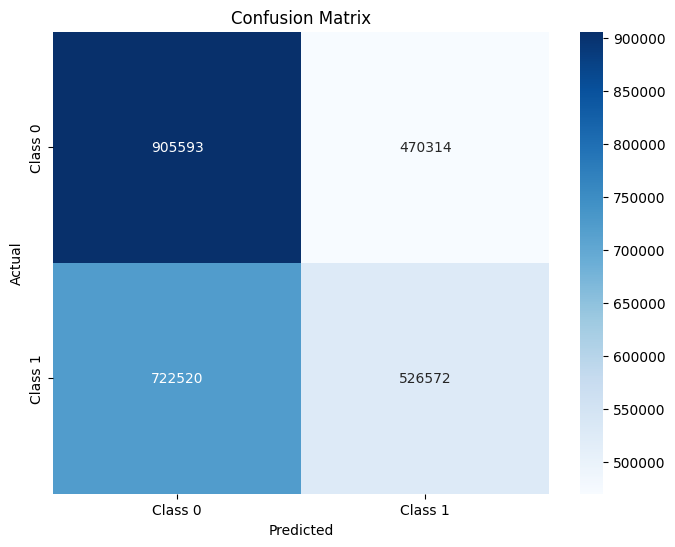


分類結果:
              precision    recall  f1-score   support

     Class 0       0.56      0.66      0.60   1375907
     Class 1       0.53      0.42      0.47   1249092

    accuracy                           0.55   2624999
   macro avg       0.54      0.54      0.54   2624999
weighted avg       0.54      0.55      0.54   2624999


機率分布統計:

Class 0 的機率分布:
平均機率: [0.5204534 0.4795457]
機率標準差: [0.04870907 0.04870906]

Class 1 的機率分布:
平均機率: [0.5098463 0.4901592]
機率標準差: [0.04830735 0.04830731]


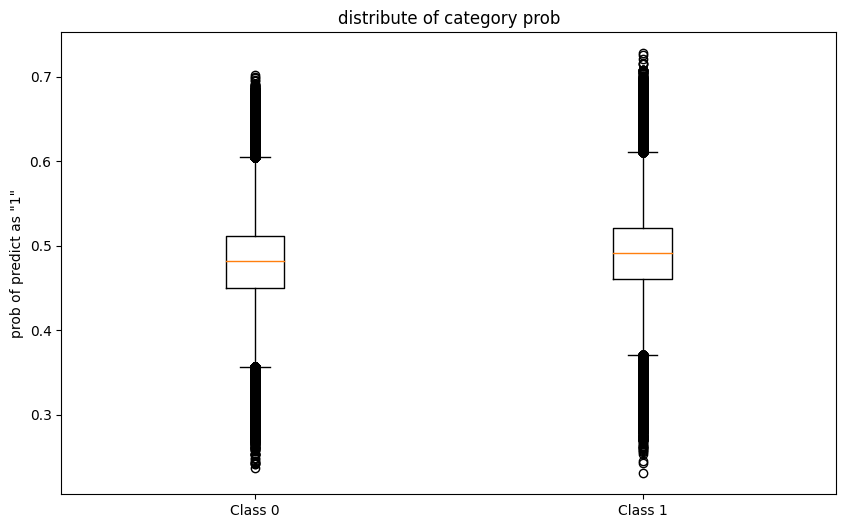

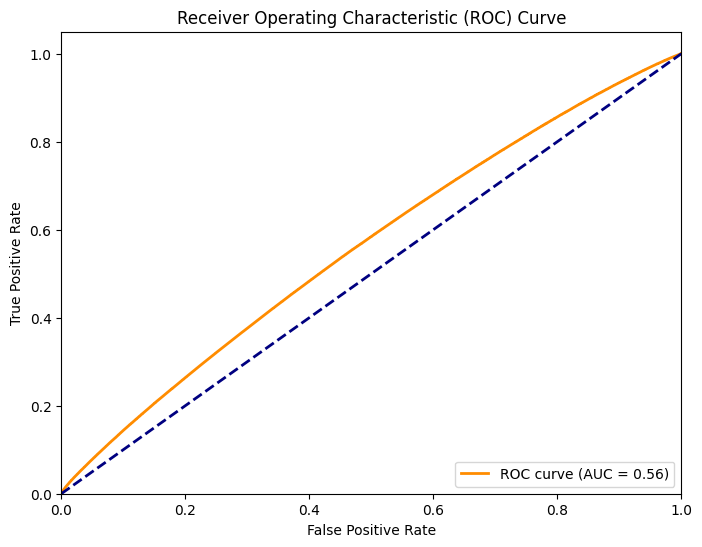


模型ACC : 0.5456


In [155]:
def main():
    try:
        device = setup_gpu()
        print(f"使用設備: {device}")
        torch.cuda.empty_cache()

        # DATA dir
        img_dir = 'C:\\Users\\user\\Desktop\\Leet\\finance\\data\\pred_5_to_5\\5_5'
        labels_file = 'C:\\Users\\user\\Desktop\\Leet\\finance\\data\\pred_5_to_5\\5_5.xlsx'

        print("Data loading...")
        dataset = CustomImageDataset(img_dir=img_dir, labels_file=labels_file)

        # data split
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) if Config.USE_RANDOM_SPLIT else (dataset, dataset)

        train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE,
                                  shuffle=True, num_workers=0, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE,
                                 shuffle=False, num_workers=0, pin_memory=True)

        print("初始化模型...")
        model = CNN5d()

        # Check if best_model.pth exists before trying to load
        import os
        if os.path.exists('best_model.pth'):
            try:
                # best model loading with new load_model function
                model, optimizer_state, epoch, loss = load_model(model, 'best_model.pth')
                print(f"Loaded model from epoch {epoch} with loss {loss}")
            except Exception as load_error:
                print(f"Error loading model: {load_error}. Proceeding with initial model.")
        else:
            print("No saved model found. Training from scratch.")

        if Config.USE_DATAPARALLEL and torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        # If no model was successfully loaded, train the model
        if not hasattr(model, 'trained'):
            print("Training model...")
            train_model(model, train_loader, test_loader, device)

        print("評估模型...")
        accuracy = evaluate_model(model, test_loader, device)

    except Exception as e:
        print(f"錯誤: {str(e)}")
        raise
    finally:
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()